# TP de SVM

L'objectif de ce TP est se de former à l'utilisation des SVMs en analyse d'images. Nous allons étudier dans un premier temps le cas d'une classification de l'ensemble d'une image (cas où une image = un point ou échantillon). Dans un second temps nous nous intéressons à la classification d'occupation des sols à partir d'imagerie satellitaire (cas où un pixel = un point). 

La première partie est réalisée sous Python afin de vous familiariser au SVM. La seconde partie sera réalisée avec un logiciel de télédétection (Orfeo Toolbox) afin de vous former à l'utilisation d'outils utiles pour vos stages.

## Première partie

Cette partie a pour objectif de vous familiariser avec le SVM sur des cas simples. Pour ce faire, nous allons commencer par entraîner un SVM à distinguer des chiffres présents sur des petites vignettes. Dans un second temps nous entraînerons le SVM à réaliser une reconnaissance faciale. Nous tenterons également de comprendre l'influence des paramètres sur les résultats du SVM et comment les optimiser.

Nous nous appuyons sur l'implémentation en Python du SVM fournie par la librairie de machine learning scikit-learn. Ce TP ne demande aucune connaissance poussée en Python. 

Il est vivement recommandé de consulter la documentation de scikit-learn sur le SVM ( https://scikit-learn.org/stable/modules/svm.html ) puisqu'elle fournit une première idée de la syntaxe du SVM pour son utilisation.

Ci-dessous, nous importons les librairies utilisées dans ce TP.

In [1]:
import numpy as np
import gdal
import gdalconst
import time
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix
from sklearn.feature_selection import RFE,RFECV

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time

np.random.seed(31415)

### Reconnaisance de chiffres

Nous allons nous servir d'un jeu de données directement disponible sous scikit-learn contenant un ensemble d'image de chiffre. L'objectif est d'obtenir un classifieur reconnaisant les chiffres présents sur des images.

On représente le jeu de données par $(x_i, y_i)_{i=1}^n$, où $x_i$ est la $i$ème image, $y_i \in \{1,\dots,10\}$ est son label associé et $n$ est le nombre d'images.

In [2]:
dataset = datasets.load_digits()
images=dataset.images
labels=dataset.target
shape=images.shape
print("Le jeu contient {} images de taille {}x{}".format(shape[0],shape[1],shape[2]))
print("La variable image est un array de dimension nb_images*nb_lignes*nb_colonnes. \nLa variable labels est un array de dimension nb_images contenant la classe de chaque images")

Le jeu contient 1797 images de taille 8x8
La variable image est un array de dimension nb_images*nb_lignes*nb_colonnes. 
La variable labels est un array de dimension nb_images contenant la classe de chaque images


1. Écrire **une fonction** plot() permettant d'afficher quelques images et leurs labels associés.

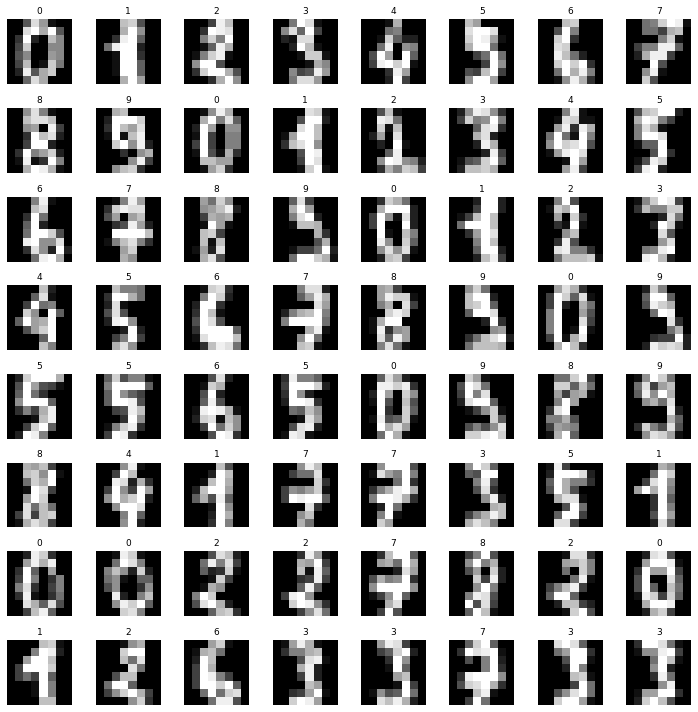

In [16]:
def plot (images,labels,cmap="gray"):
    plt.figure(figsize=(10,10))
    compt=1
    for (image, label) in zip(images,labels[:64]):
        plt.subplot(8, 8, compt)
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.title('{}'.format(label),size=9)
        compt+=1
    plt.tight_layout()
    plt.show()
plot(images,labels)

2. Pour la suite du TP, il est intéressant de réécrire les images actuellement sous la forme d'un array de dimension (nb_images, nb_lignes, nb_colonnes) sous la forme d'un array (nb_images, nb_pixels). Écrire une fonction reshape() prenant un array de dimension (nb_images, nb_lignes, nb_colonnes) et le renvoyant sous la forme d'une matrice (nb_images, nb_pixels).


In [28]:
def reshape(data):
  return np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))

im = reshape(images)

(1797, 8, 8)
(1797, 64)


3. Nous disposons de suffisamment de données (64 images de 1797 pixels) afin séparer notre jeu de données en un jeu d'**entraînement** $(x_{train}, y_{train})$ et un jeu de **test** $(x_{test}, y_{test})$. Notre SVM apprendra sur le jeu d'entraînement et ses performances seront évaluées sur le jeu de test. Écrire une fonction séparant en deux jeux distincts (entraînement et test) notre jeu de données. La séparation doit être **aléatoire** et si l'image $x_i$ est attribuée au jeu de test, son label $y_i$ doit l'être aussi.

**Indication** : pour cette question, on pourra directement utiliser la fonction train_test_split() de scikit-learn. Assurez-vous de bien avoir compris ce que réalise cette fonction avant de passer à la suite. 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(im, labels, train_size=0.75, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(1347, 64)
(450, 64)


4. Écrire le code (deux lignes suffisent) qui réalise l'entraînement du SVM pour un noyau et un paramétrage donnés, sur les données d'entraînement.

In [29]:
def train_svm(X_train,y_train,kernel="linear",C=1):
    model=svm.SVC(kernel=kernel,C=C)
    return model.fit(X_train,y_train)
model=train_svm(X_train,y_train)

5. Écrire le code (une ligne) qui permet de tester le modèle (que nous venons d'entraîner en Q4) sur les données de test. On utilisera la fonction predict() de la classe SVM(), qui renvoie les prédictions sur le jeu de test, c-a-d la classe supposée de chaque image du jeu de test. Attention, ici, nous n'avons pas besoin de $y_{test}$ !

Quelle est la différence entre les fonctions fit() et predict() ?

In [30]:
def test_svm(X_test,model):
    prediction = model.predict(X_test)
    return prediction
prediction=test_svm(X_test,model)

6. Écrire une fonction stats() qui affiche la précision, le rappel et le f-score pour chaque classe ainsi que la matrice de confusion. Elle affiche également quelques images avec leurs prédictions.

**Indication** : on utilisera successivement les fonctions classification_report() et confusion_matrix() de scikit-learn.

In [31]:
def stats(X_test, y_test, prediction, model):
  print(classification_report(y_test, prediction))
stats(X_test, y_test, prediction, model)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.95      1.00      0.97        55
           2       1.00      1.00      1.00        44
           3       1.00      0.97      0.99        36
           4       1.00      1.00      1.00        42
           5       0.96      1.00      0.98        47
           6       1.00      1.00      1.00        45
           7       1.00      1.00      1.00        53
           8       0.98      0.94      0.96        49
           9       1.00      0.94      0.97        36

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



**Félicitations** ! Vous avez entrainé votre tout premier SVM et il donne des résultats très convainquants. Au vu de ces performances, il ne semble pas nécessaire de chercher à optimiser ses résultats.  

7. Bien que la sélection d'attributs ne soit pas utile dans le cas présent (calcul très rapide), je vous propose de vous interroger sur la pertinence de certains attributs.
   - À quoi correspond un attribut dans le cas présent ?
   - Combien d'attributs comporte le problème ?
   - Lesquels vous paraît-il possible d'enlever sans impacter la qualité du classifieur ?

8. Implémenter une fonction s'appuyant sur le RFE et la CV (cross-validation) pour déterminer à partir de combien d'attributs les performances atteignent un palier.

**Indication** : encore une fois, scikit-learn fait bien les choses. On pourra utiliser la classe RFECV() avec un SVM comme estimateur. À vous de régler les autres paramètres (step, cv, scoring, *etc.*).

9.  Montrer les pixels correspondant aux $n$ attributs à conserver.

### Reconnaissance de visage

Cette partie aborde brièvement la reconnaissance de visage à l'aide d'un SVM. Elle a vocation à permettre de mieux comprendre l'influence des différents paramètres sur le SVM avec un exemple moins simple que le précédent, c'est-à-dire nécessitant une **optimisation**.

Il est important de noter qu'en pratique on préfèrera des méthodes de deep learning pour ce genre d'application !

In [ ]:
dataset=fetch_lfw_people( resize=1, min_faces_per_person=50, color=True, download_if_missing=True)
images=dataset.images
labels=dataset.target
name=dataset.target_names
name=[name[i] for i in labels]
shape=images.shape
print("Le jeu contient {} images de taille {}x{}".format(shape[0],shape[1],shape[2]))
print("La variable image est un array de dimension nb_images*nb_lignes*nb_colonnes*nb_couleurs. \nLa variable labels est un array de dimension nb_images contenant la classe de chaque images")
unique, counts = np.unique(labels, return_counts=True)
print("il y a {} personnes différentes dans le jeu de données".format(len(unique)))
plot(images,name,normalize=True)

1. En vous servant du code précédent, redimensionnez vos données correctement.

2. Notre espace de description ayant un très grand nombre de dimensions (nb_couleurs * nb_lignes * nb_colonnes), nous allons devoir réduire le nombre de dimensions. Pour ce faire, nous allons procéder par analyse en composante principales (ACP), une méthode par filtre (plus rapide que SVM-RFE) très utilisée en reconnaissance faciale et en télédétection. L'ACP comme le SVM sont des méthodes sensibles aux fortes variations d'amplitudes entre les attributs. Les variations dans ce jeu de données étant fortes, il est important de **standardiser** les données. Utiliser le StandardScaler() de scikit-learn pour réaliser la standardisation (trois lignes de code).

3. Séparez le jeu de données standardisé en un jeu d'entraînement et un jeu de test.

4. Écrire le code réalisant une ACP s'ajustant aux données d'entraînement et l'appliquer à la fois aux données d'entraînement et de test. Elle doit renvoyer $k$ attributs pour chaque image ($k=150$ est un bon choix pour commencer).

5. Entrainez le SVM et évaluez ses résultats.

6. On constate ici que les résultats sont loin d'être aussi bons que précédemment. Nous allons donc tenter d'optimiser les paramètres de notre SVM. Essayez de jouer "à la main" sur les paramètres C et les paramètres de noyaux pour voir leur impact sur la qualité des résultats. Vous pouvez également jouer sur la métrique à optimiser (précision, rappel, fscore). 

7. Nous allons maintenant tenter d'écrire une fonction permettant de déterminer plus efficacement les résultats optimaux de notre méthode. Cette fonction va nécessairement devoir entrainer plusieurs fois le SVM avec différents paramètres et évaluer à chaque fois les résultats pour ne retenir que le meilleur paramétrage. 
  * L'évaluation de la qualité des résultats ne peut pas se faire sur le jeu de test. Pourquoi ?
  * Proposer deux solutions permettant de contourner ce problème.

8. Écrire une version évoluée du code de la question 4 dans une fonction train_SVM(), de sorte qu'elle procède à une cross-validation pour déterminer les meilleurs paramètres du SVM.

## Partie 2: réaliser une classification d'occupation des sols

Cette partie du TP s'effectue à l'aide du logiciel Orfeo toolbox https://www.orfeo-toolbox.org/. Nous allons ici utiliser son interface simple. Sachez qu'il est également possible de se servir de QGIS, de l'interface graphique propre d'OTB, ou de Python pour utiliser OTB.
L'objectif est de réaliser la classification d'occupation des sols d'une image sentinel 2.

Les images Sentinel 2 sont des images optiques à 13 bandes. Les bandes vont de B1 (bleu) à B12 (moyen infra-rouge). Les bandes RVB classiques sont B2 (bleu), B3 (vert), B4 (rouge). Les bandes B8 et B8A sont les bandes du proche infra-rouge. Les bandes ont des résolutions différentes (10m, 20m, 60m). Pour former une unique image nous les avons toutes ré-échantillonnées à 10m.

1. Ouvrir le projet sous QGIS pour avoir un premier aperçu des données.


Il est nécessaire de disposer d'un jeu d'entrainement et de 
validation pour entrainer notre classifieur. Plusieurs approches sont 
possible pour en obtenir un : enquête terrain, utilisation de données 
d'occupation des sols (OCS-GE par exemple), ou simplement par 
photo-interprétation. Chacune de ces méthodes présente son lot 
d'avantages et d'inconvénients :
  - Les enquêtes terrains sont longues à mettre en place et ne couvrent généralement qu'une petite zone. Elles ont pour avantage de permettre la construction d'un jeu de données fiables !
  - Les données déjà établies d'occupation des sols sont des jeux d'entrainement beaucoup plus rapide à utiliser. Ils ont deux inconvénients majeurs : ils contiennent des erreurs pouvant fausser votre algorithme et vous n'en trouverez pas nécessairement un réalisé à la même époque que votre image.
  - La photo-interprétation rend plus rapide la création du jeu de données que par enquêtes terrain mais plus longue que par l'utilisation de données pré-existantes. Un risque est de mal photo-interpréter les images et donc d'inclure des erreurs.


 2. Créer un jeu de données par photo-interprétation :

      -  Créer une nouvelle couche shapefile contenant un unique attribut 
        classe de type integer et acceptant des géométries de type polygones.
      -  Tracez un premier polygone sur une zone de forêt et attribuez-lui la
         classe 1. Tracer ainsi 4 à 5 polygones sur différentes zones de forêt 
        dans l'image. 
      -   Recommencer cette étape sur des zones de différentes natures (eau, 
        bâti, champ moissonné, culture ...) en leur attribuant respectivement la classe (2,3,4,5 ...).

3. Connaissez-vous un indice permettant de mieux distinguer le bâti du non-bâti ?

  - Ajouter cet indice à votre image. Pour ce faire, ouvrez le fichier intitulé mapla.bat du répertoire otb. La fenêtre qui s'ouvre vous montre toutes les fonctions existantes. Sélectionnez bandmathx et ajoutez votre 14ème bande.

4.  OTB réalisera pour nous la normalisation des données si on lui fournit les statistiques de chaque bande de l'image. Pour calculer ces statistiques, sélectionnez ComputeImageStatistic. Stockez le résultat dans un fichier stat.xml.

5.  Nous n'avons pas besoin de séparer notre jeu de données en un jeu de test et un jeu d'entraînement car OTB s'en charge pour nous ! Nous allons donc maintenant pouvoir entrainer notre classifieur. Pour cela, sélectionnez TrainImageClassifier. N'oubliez pas de fournir le fichier stat.xml. Sauvegardez le modèle dans un fichier modele.txt. Choisir un SVM avec un noyau linéaire. Pour le premier essai, ne pas choisir l'option d'optimisation des paramètres. Une fois qu'il a fini de tourner,allez dans l'onglet log pour regarder la matrice de confusion, la précision, le rappel et le fscore. Choisir d'optimiser les paramètres et recommencez.

6.  Maintenant que nous avons un modèle il ne nous reste plus qu'à classer l'image. Pour ce faire sélectionnez ImageClassifier. N'oubliez pas de fournir le fichier stat.xml. Regardez et analysez le résultat sous QGIS.

7. On constate un léger effet poivre et sel (quelques pixels épars mal classés). Pour cela utilisez QGIS. Pour améliorer le rendu, procédez à un tamisage. Il vous faut alors théoriquement ré-évaluer vos résultats, ce qu'on ne fera pas dans ce TP pour des raisons de temps.

8. S'il vous reste du temps, recommencez les étapes 3 à 5 avec d'autres classifieurs et tentez de voir le rendu d'une ACP.

**Si vous désirez conserver une copie de ce TP au format pdf : ouvrez une console et taper jupyter nbconvert --to pdf tp_svm.ipynb**